# Proceso de análisis y limpieza de datos

In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

import warnings

# Desactivar las advertencias de DeprecationWarning
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", category=DeprecationWarning)


/Users/Sebastian/Desktop/Cursos Platzi/missing_imputation/missing_env/lib/python3.9/site-packages/nhanes/load.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/Sebastian/Desktop/Cursos Platzi/missing_imputation/missing_env/lib/python3.9/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/Users/Sebastian/Desktop/Cursos Platzi/missing_imputation/missing_env/lib/python3.9/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to

## Librerias personalizadas

In [26]:
%run pandas-missing-extension.ipynb

## Cargar datos de NHANES

In [14]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(case_type="snake") # Para que me de los nombres separados por "_"
)


In [18]:
print(f"El dataset de tiene {nhanes_raw_df.shape[0]} filas y {nhanes_raw_df.shape[1]} columnas. Para un totla de datos de {nhanes_raw_df.shape[0] * nhanes_raw_df.shape[1]}")

El dataset de tiene 8366 filas y 197 columnas. Para un totla de datos de 1648102


In [16]:
nhanes_raw_df.head()

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Porcesar los datos NHANES

In [29]:
nhanes_df = (
    nhanes_raw_df
    .select_columns(
        "general_health_condition",
        "age_in_years_at_screening",
        "gender",
        "current_selfreported_height_inches",
        "current_selfreported_weight_pounds",
        "doctor_told_you_have_diabetes",
        "60_sec_pulse30_sec_pulse2",
        "total_cholesterol_mgdl"
    )
    .rename_columns(
        {
        "age_in_years_at_screening":"age",
        "current_selfreported_height_inches":"height",
        "current_selfreported_weight_pounds":"weight",
        "doctor_told_you_have_diabetes":"diebetes",
        "60_sec_pulse30_sec_pulse2":"pulse",
        "total_cholesterol_mgdl": "total_cholesterol"           
        }
    )
    .replace(
        {
            "height": {
                9999 : np.nan,
                7777 : np.nan
            },
            "weight": {
                9999 : np.nan,
                7777 : np.nan
            },
            "diebetes":{
                "Borderline": np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset = ["diebetes"],
        how = "any"
    )
    .transform_column(
        column_name = "diebetes",
        function = lambda s : s.astype(int),
        elementwise = False
    )

 
)

In [30]:
nhanes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8187 entries, 93703.0 to 102956.0
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   height                    5488 non-null   float64
 1   weight                    5553 non-null   float64
 2   general_health_condition  5797 non-null   object 
 3   total_cholesterol         6565 non-null   float64
 4   pulse                     6570 non-null   float64
 5   diebetes                  8187 non-null   int64  
 6   age                       8187 non-null   float64
 7   gender                    8187 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 575.6+ KB


# Visualizar y eliminar valores faltantes

## Visualizar valores faltantes

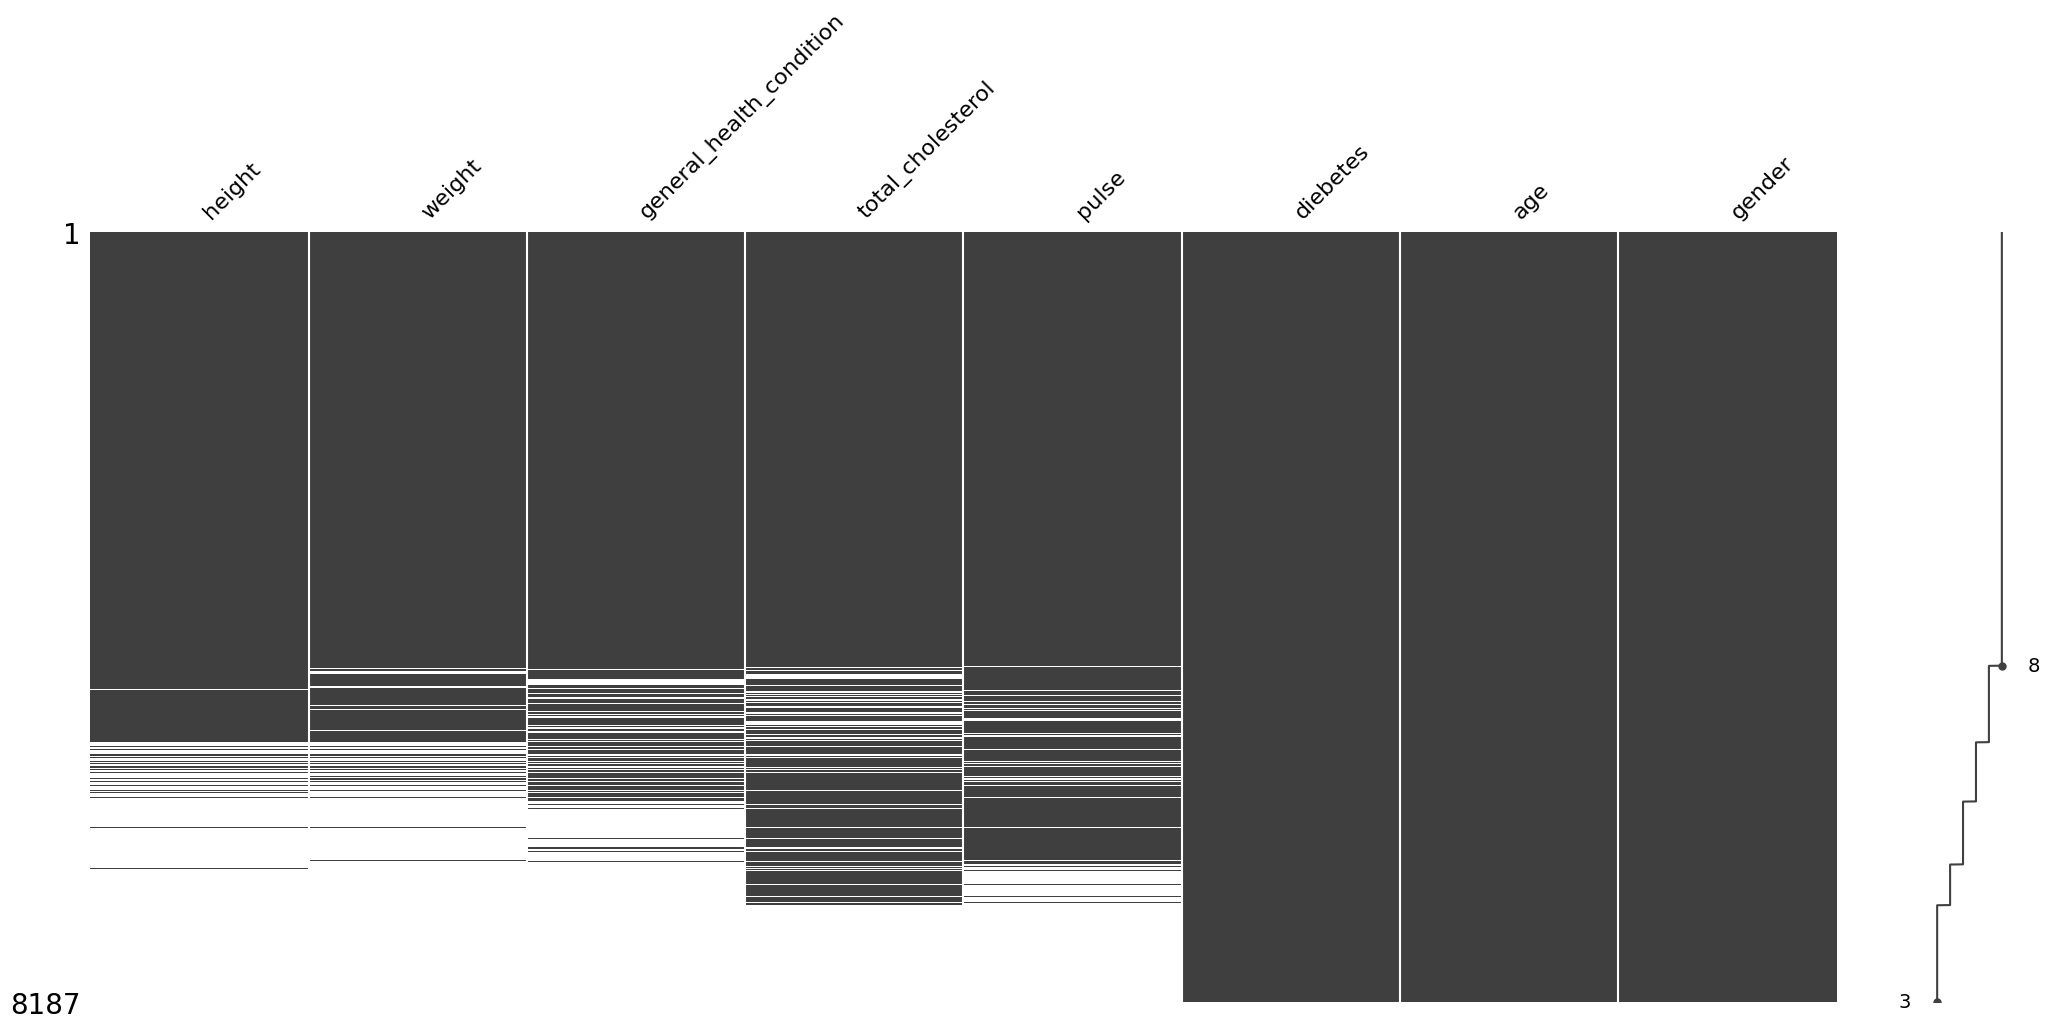

In [31]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix, sort = "descending")
);

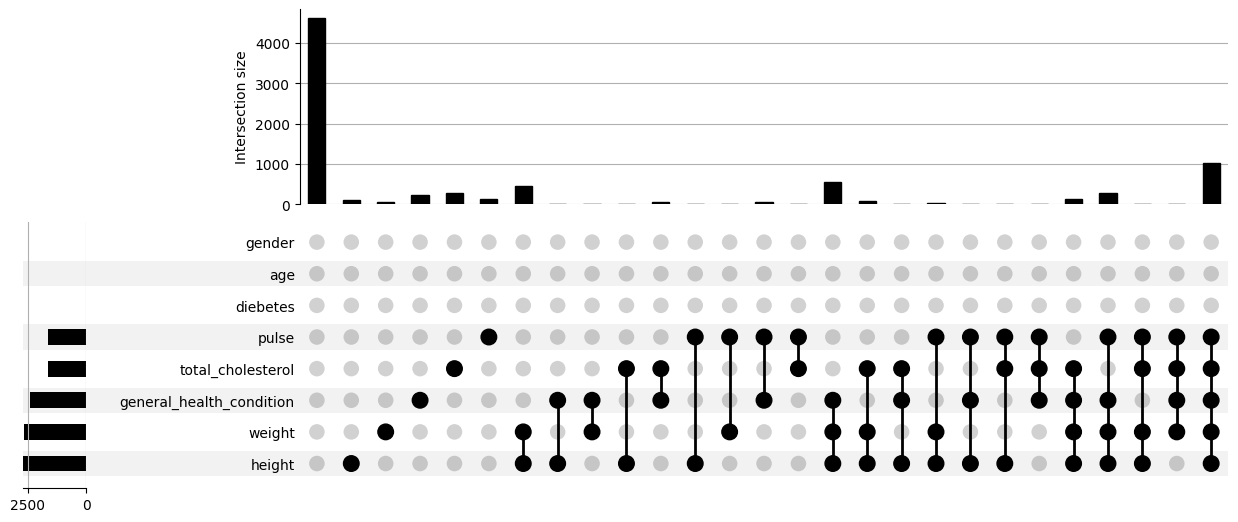

In [32]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
);

## Elimina valores faltantes

In [33]:
nhanes_df = (
    nhanes_df
    .dropna(
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
    
    
)
nhanes_df.shape

(7157, 8)

In [36]:
print(f"El dataset resultante, después de eliminar algunos datos faltantes es de {nhanes_df.shape[0]} columnas y {nhanes_df.shape[1]} filas. Para un totla de datos de {nhanes_df.shape[0] * nhanes_df.shape[1]}")

El dataset resultante, después de eliminar algunos datos faltantes es de 7157 columnas y 8 filas. Para un totla de datos de 57256
